In [13]:
import pandas as pd
import datetime
import numpy as np

# Function to convert quarter to datetime
def convert_qtr_to_date(qtr):
    qtr, year = qtr.split('FY')
    if qtr == 'Q1':
        month = 1
    elif qtr == 'Q2':
        month = 4
    elif qtr == 'Q3':
        month = 7
    elif qtr == 'Q4':
        month = 10
    year = int(year) + 2000
    return datetime.datetime(year, month, 1)

# Load the data from the Excel file
df = pd.read_excel("platform_3m_actuals_new.xlsx")

# Filter out the data for the 8k_Chassis platform
###Change platform looking at here
platform = '8k_Chassis'
data = df[df['Platform'] == platform]

# Convert the 'qtr' column to datetime
data['sdate'] = data['qtr'].apply(convert_qtr_to_date)

C:\Users\lebobb\AppData\Local\Temp\ipykernel_26840\277043629.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sdate'] = data['qtr'].apply(convert_qtr_to_date)


In [14]:
# Calculate the mean and deviation over a rolling window of 3 quarters for Actuals
data = data.sort_values(by="sdate")
data['mean'] = data['Bookings_3m'].rolling(window=3).mean()
data['deviation'] = data['Bookings_3m'].rolling(window=3).std()

# The naive mean and naive deviation are the last values from the 'mean' and 'deviation' columns
data['naivemean'] = data['mean'].shift(1)
data['naivedeviation'] = data['deviation'].shift(1)

# Calculate the lower limit and upper limit based on naivemean and naivedeviation
data['lower limit'] = data['naivemean'] - 3*data['naivedeviation']
data['upper limit'] = data['naivemean'] + 3*data['naivedeviation']

# Calculate the Z-score
data['z_score'] = (data['Bookings_3m'] - data['naivemean']) / data['naivedeviation']

# Identify outliers based on Z-score
data['actuals_outlier'] = np.abs(data['z_score']) > 3

# Adjust the outliers
data['actuals_adjusted'] = data.apply(
    lambda row: row['naivemean'] + 3*row['naivedeviation'] if row['z_score'] > 3
                else row['naivemean'] - 3*row['naivedeviation'] if row['z_score'] < -3
                else row['Bookings_3m'], axis=1
)

In [10]:
# # Save to csv
# data.to_csv('data_actuals_adjusted.csv', index=False)

# Load the forecast data
df_forecast = pd.read_csv("mviai_platform_3m_forecast.csv")

# Filter out the data for the 8k_Chassis platform
df_forecast = df_forecast[df_forecast['Platform'] == platform]

# Convert the 'qtr' column in the forecast data to datetime
df_forecast['fdate'] = df_forecast['qtr'].apply(convert_qtr_to_date)

# Sort the forecast data by 'fdate'
df_forecast = df_forecast.sort_values(by="fdate")

# Merge data with df_forecast on the dates
data = pd.merge(data, df_forecast[['fdate', 'Forecast_3m']], left_on='sdate', right_on='fdate', how='left')

print(data.head(10))

#save to csv
# data.to_csv('data_actuals_adjusted_forecast.csv', index=False)

   datestamp    Platform  Bookings_3m  Booking_Cost_3m  Customer_Count  \
0 2019-10-31  8k_Chassis          4.0         554.1315        1.000000   
1 2020-01-31  8k_Chassis         36.0      159008.7300        2.000000   
2 2020-04-30  8k_Chassis         29.0       86121.3400        6.435112   
3 2020-07-31  8k_Chassis        124.0      296642.3800       11.693187   
4 2020-10-31  8k_Chassis        724.0      226444.5600        6.018927   
5 2021-01-31  8k_Chassis       4135.0      442931.9400        1.974265   
6 2021-04-30  8k_Chassis       1586.0      115041.6700        3.764359   
7 2021-07-31  8k_Chassis       1102.0      172381.7500        6.398777   
8 2021-10-31  8k_Chassis       3424.0      252413.6100        1.271224   
9 2022-01-31  8k_Chassis       2433.0      158047.4200        1.871127   

    Run_Rate    Age_STD     qtr      sdate         mean    deviation  \
0   2.000000   61.00000  Q1FY20 2020-01-01          NaN          NaN   
1   3.000000   31.00000  Q2FY20 2020-04-0

In [19]:
# Calculate the mean and deviation over a rolling window of 3 quarters for Forecast
df_forecast = df_forecast.sort_values(by="fdate")
df_forecast['mean'] = df_forecast['Forecast_3m'].rolling(window=3).mean()
df_forecast['deviation'] = df_forecast['Forecast_3m'].rolling(window=3).std()

# The naive mean and naive deviation are the last values from the 'mean' and 'deviation' columns
df_forecast['naivemean'] = df_forecast['mean'].shift(1)
df_forecast['naivedeviation'] = df_forecast['deviation'].shift(1)

# Calculate the lower limit and upper limit based on naivemean and naivedeviation
df_forecast['lower limit'] = df_forecast['naivemean'] - 3*df_forecast['naivedeviation']
df_forecast['upper limit'] = df_forecast['naivemean'] + 3*df_forecast['naivedeviation']

# Calculate the Z-score
df_forecast['z_score'] = (df_forecast['Forecast_3m'] - df_forecast['naivemean']) / df_forecast['naivedeviation']

# Identify outliers based on Z-score
df_forecast['actuals_outlier'] = np.abs(df_forecast['z_score']) > 3

# Adjust the outliers
df_forecast['actuals_adjusted'] = df_forecast.apply(
    lambda row: row['naivemean'] + 3*row['naivedeviation'] if row['z_score'] > 3
                else row['naivemean'] - 3*row['naivedeviation'] if row['z_score'] < -3
                else row['Forecast_3m'], axis=1
)

df_forecast.head()

,Platform,qtr,Forecast_3m,fdate,mean,deviation,naivemean,naivedeviation,lower limit,upper limit,z_score,actuals_outlier,actuals_adjusted
1,8k_Chassis,Q2FY21,3924,2021-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,3924.0
3,8k_Chassis,Q3FY21,8242,2021-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,8242.0
5,8k_Chassis,Q4FY21,9506,2021-10-01,7224.000000,2926.930816,NaN,NaN,NaN,NaN,NaN,False,9506.0
0,8k_Chassis,Q1FY22,3566,2022-01-01,7104.666667,3129.064610,7224.000000,2926.930816,-1556.792447,16004.792447,-1.249773,False,3566.0
2,8k_Chassis,Q2FY22,6495,2022-04-01,6522.333333,2970.094331,7104.666667,3129.064610,-2282.527163,16491.860497,-0.194840,False,6495.0


## Lexi's Revamp PART 1 - 3m Data - With Actuals Known

### Settings

In [288]:
import pandas as pd
import openpyxl
from openpyxl.drawing.image import Image
import matplotlib.pyplot as plt

In [567]:
###Change platform looking at here
platform = '8k_Chassis'

#Platform Options
#NGFWBU_Ultra High End
#8k_Chassis
#8k_Fabric Card
#NCS_Fixed - 4.8T

### 1. Read in forecast file and make adjustments (dates, platform, etc)

In [568]:
#Read in Forecast file and make adjustments
df_forecast = pd.read_csv("mviai_platform_3m_forecast.csv")

# Filter out the data for the 8k_Chassis platform
df_forecast = df_forecast[df_forecast['Platform'] == platform]

# Convert the 'qtr' column in the forecast data to datetime
df_forecast['fdate'] = df_forecast['qtr'].apply(convert_qtr_to_date)

# Sort the forecast data by 'fdate'
df_forecast = df_forecast.sort_values(by="fdate")

In [569]:
# df_forecast

### 2. Read in actuals file and make adjustments (dates, platform, etc)

In [570]:
#Read in actuals file and make adjustment
# Load the data from the Excel file
df = pd.read_excel("platform_3m_actuals_new.xlsx")

# Filter out the data for the 8k_Chassis platform
data = df[df['Platform'] == platform]

# Convert the 'qtr' column to datetime
data['sdate'] = data['qtr'].apply(convert_qtr_to_date)

C:\Users\lebobb\AppData\Local\Temp\ipykernel_26840\2466057672.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sdate'] = data['qtr'].apply(convert_qtr_to_date)


In [571]:
# data

### 3. Create Naive Mean and Standard Deviation Using Actuals

In [572]:
data = data.sort_values(by="sdate")
data['mean'] = data['Bookings_3m'].rolling(window=3).mean()
data['deviation'] = data['Bookings_3m'].rolling(window=3).std()

# The naive mean and naive deviation are the last values from the 'mean' and 'deviation' columns
data['naivemean'] = data['mean'].shift(1)
data['naivedeviation'] = data['deviation'].shift(1)

# Calculate the lower limit and upper limit based on naivemean and naivedeviation
data['lower limit'] = data['naivemean'] - 3*data['naivedeviation']
data['upper limit'] = data['naivemean'] + 3*data['naivedeviation']

In [573]:
# data

### 4. Merge Datasets and fill NaN

In [574]:
df_merge = pd.merge(data, df_forecast[['fdate', 'Forecast_3m']], left_on='sdate', right_on='fdate', how='left')

In [575]:
# df_merge

In [576]:
# df_merge["Forecast_3m"].fillna(0, inplace=True)
# df_merge["Bookings_3m"].fillna(0, inplace=True)

### 5. Calculate Z-scores for Forecast Data

In [577]:
# Calculate the Z-score
df_merge['z_score'] = (df_merge['Forecast_3m'] - df_merge['naivemean']) / df_merge['naivedeviation']
#df_merge['z_score'].fillna(0, inplace=True)

In [578]:
# df_merge

### 6. Identify Outliers in Forecast Based on 3 standard deviations

In [579]:
# Identify outliers based on Z-score
df_merge['actuals_outlier'] = np.abs(df_merge['z_score']) > 3

### 7. Dataframe Check

In [580]:
columns_to_drop = ['qtr','Booking_Cost_3m','Customer_Count','Run_Rate','Age_STD']
df_merge = df_merge.drop(columns_to_drop, axis = 1)
df_merge.head(20)

,datestamp,Platform,Bookings_3m,sdate,mean,deviation,naivemean,naivedeviation,lower limit,upper limit,fdate,Forecast_3m,z_score,actuals_outlier
0,2019-10-31,8k_Chassis,4.0,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,False
1,2020-01-31,8k_Chassis,36.0,2020-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,False
2,2020-04-30,8k_Chassis,29.0,2020-07-01,23.000000,16.822604,NaN,NaN,NaN,NaN,NaT,NaN,NaN,False
3,2020-07-31,8k_Chassis,124.0,2020-10-01,63.000000,52.943366,23.000000,16.822604,-27.467812,73.467812,NaT,NaN,NaN,False
4,2020-10-31,8k_Chassis,724.0,2021-01-01,292.333333,376.839931,63.000000,52.943366,-95.830098,221.830098,NaT,NaN,NaN,False
5,2021-01-31,8k_Chassis,4135.0,2021-04-01,1661.000000,2163.447943,292.333333,376.839931,-838.186459,1422.853125,2021-04-01,3924.0,9.637160,True
6,2021-04-30,8k_Chassis,1586.0,2021-07-01,2148.333333,1773.666917,1661.000000,2163.447943,-4829.343828,8151.343828,2021-07-01,8242.0,3.041904,True
7,2021-07-31,8k_Chassis,1102.0,2021-10-01,2274.333333,1629.455226,2148.333333,1773.666917,-3172.667418,7469.334085,2021-10-01,9506.0,4.148280,True
8,2021-10-31,8k_Chassis,3424.0,2022-01-01,2037.333333,1225.029523,2274.333333,1629.455226,-2614.032344,7162.699011,2022-01-01,3566.0,0.792698,False
9,2022-01-31,8k_Chassis,2433.0,2022-04-01,2319.666667,1165.141336,2037.333333,1225.029523,-1637.755237,5712.421904,2022-04-01,6495.0,3.638824,True


### 8. Adjust the Outliers

In [581]:
# Adjust the outliers
df_merge['forecast_adjusted'] = df_merge.apply(
    lambda row: row['naivemean'] + 3*row['naivedeviation'] if row['z_score'] > 3
                else row['naivemean'] - 3*row['naivedeviation'] if row['z_score'] < -3
                else row['Forecast_3m'], axis=1
)

In [582]:
df_merge

,datestamp,Platform,Bookings_3m,sdate,mean,deviation,naivemean,naivedeviation,lower limit,upper limit,fdate,Forecast_3m,z_score,actuals_outlier,forecast_adjusted
0,2019-10-31,8k_Chassis,4.0,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,False,NaN
1,2020-01-31,8k_Chassis,36.0,2020-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,False,NaN
2,2020-04-30,8k_Chassis,29.0,2020-07-01,23.000000,16.822604,NaN,NaN,NaN,NaN,NaT,NaN,NaN,False,NaN
3,2020-07-31,8k_Chassis,124.0,2020-10-01,63.000000,52.943366,23.000000,16.822604,-27.467812,73.467812,NaT,NaN,NaN,False,NaN
4,2020-10-31,8k_Chassis,724.0,2021-01-01,292.333333,376.839931,63.000000,52.943366,-95.830098,221.830098,NaT,NaN,NaN,False,NaN
5,2021-01-31,8k_Chassis,4135.0,2021-04-01,1661.000000,2163.447943,292.333333,376.839931,-838.186459,1422.853125,2021-04-01,3924.0,9.637160,True,1422.853125
6,2021-04-30,8k_Chassis,1586.0,2021-07-01,2148.333333,1773.666917,1661.000000,2163.447943,-4829.343828,8151.343828,2021-07-01,8242.0,3.041904,True,8151.343828
7,2021-07-31,8k_Chassis,1102.0,2021-10-01,2274.333333,1629.455226,2148.333333,1773.666917,-3172.667418,7469.334085,2021-10-01,9506.0,4.148280,True,7469.334085
8,2021-10-31,8k_Chassis,3424.0,2022-01-01,2037.333333,1225.029523,2274.333333,1629.455226,-2614.032344,7162.699011,2022-01-01,3566.0,0.792698,False,3566.000000
9,2022-01-31,8k_Chassis,2433.0,2022-04-01,2319.666667,1165.141336,2037.333333,1225.029523,-1637.755237,5712.421904,2022-04-01,6495.0,3.638824,True,5712.421904


In [583]:
# df_forecast

### 9. Graph It

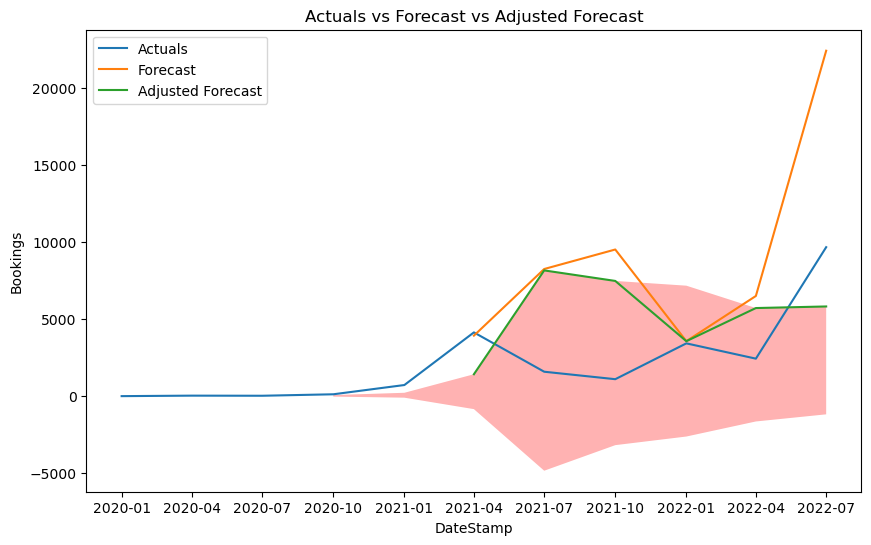

In [584]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))

x = df_merge['sdate']
y1 = df_merge['Bookings_3m']
y2 = df_merge['Forecast_3m']
y3 = df_merge['forecast_adjusted']

# Plotting the first dataset
ax.plot(x, y1, label='Actuals')

# Plotting the second dataset
ax.plot(x, y2, label='Forecast')

# Plotting the second dataset
ax.plot(x, y3, label='Adjusted Forecast')

ax.legend()
ax.set_xlabel('DateStamp')
ax.set_ylabel('Bookings')
ax.set_title('Actuals vs Forecast vs Adjusted Forecast')

y_lower = df_merge['lower limit']
y_upper = df_merge['upper limit']

ax.fill_between(x, y_lower, y_upper, facecolor='red', alpha=0.3)

# Save the graph as an image
img_path = 'graph_image.png'  # Replace this with the path where you want to save the graph image
plt.savefig(img_path)

plt.show()

### 10. Looking at Accuracies and Smape

In [585]:
# Assuming df_merge is a pandas DataFrame, not a list
df_analysis = pd.DataFrame()

#Accuracy
#Increase is accuracy is a good thing, looking for positive number in the diff column
# Perform operations on the DataFrame
df_analysis['datestamp'] = df_merge['datestamp']
df_analysis['Platform'] = df_merge['Platform']
df_analysis['original_accuracy'] = 1 - np.abs((df_merge['Forecast_3m'] - df_merge['Bookings_3m']) / df_merge['Bookings_3m'])
df_analysis['new_accuracy'] = 1 - np.abs((df_merge['forecast_adjusted'] - df_merge['Bookings_3m']) / df_merge['Bookings_3m'])
df_analysis['diff_accuracy'] = df_analysis['new_accuracy'] - df_analysis['original_accuracy']

#SMAPE
#Decrease in SMAPE is a good thing, looking for negative number in the diff column
#=ABS(Forecast-Bookings)/((ABS(Forecast)+ABS(Bookings))/2)
df_analysis['original_SMAPE'] = np.abs(df_merge['Forecast_3m'] - df_merge['Bookings_3m']) / ((df_merge['Forecast_3m'] + df_merge['Bookings_3m']) / 2)
df_analysis['new_SMAPE'] = np.abs(df_merge['forecast_adjusted'] - df_merge['Bookings_3m']) / ((df_merge['forecast_adjusted'] + df_merge['Bookings_3m']) / 2)
df_analysis['diff_SMAPE'] = df_analysis['new_SMAPE'] - df_analysis['original_SMAPE']


In [586]:
#df_analysis

In [587]:
df_analysis

,datestamp,Platform,original_accuracy,new_accuracy,diff_accuracy,original_SMAPE,new_SMAPE,diff_SMAPE
0,2019-10-31,8k_Chassis,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-31,8k_Chassis,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-04-30,8k_Chassis,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-07-31,8k_Chassis,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-10-31,8k_Chassis,NaN,NaN,NaN,NaN,NaN,NaN
5,2021-01-31,8k_Chassis,0.948972,0.344100,-0.604872,0.052364,0.975969,0.923605
6,2021-04-30,8k_Chassis,-3.196721,-3.139561,0.057160,1.354497,1.348488,-0.006010
7,2021-07-31,8k_Chassis,-6.626134,-4.777980,1.848154,1.584465,1.485728,-0.098737
8,2021-10-31,8k_Chassis,0.958528,0.958528,0.000000,0.040629,0.040629,0.000000
9,2022-01-31,8k_Chassis,-0.669544,-0.347892,0.321651,0.909946,0.805218,-0.104728


### 11. Adjust forecast (for the 2nd time) if accuracy is decreased instead of increased, regraph, redo accuracies

#### 8k_Chassis is an example of this happening

In [588]:
df_final = pd.DataFrame()
# Merge based on index
df_final = pd.merge(df_analysis, df_merge[['Bookings_3m', 'Forecast_3m', 'forecast_adjusted']], left_index=True, right_index=True, how='left')

In [589]:
# Adjust the outliers
df_final['forecast_adjusted'] = df_final.apply(
    lambda row: row['Forecast_3m'] if row['original_accuracy'] > row['new_accuracy']
                else row['forecast_adjusted'], axis=1
)

In [590]:
#df_final

### 12. Redo Graph, Stats, and remerge dataframes to get final adjusted values

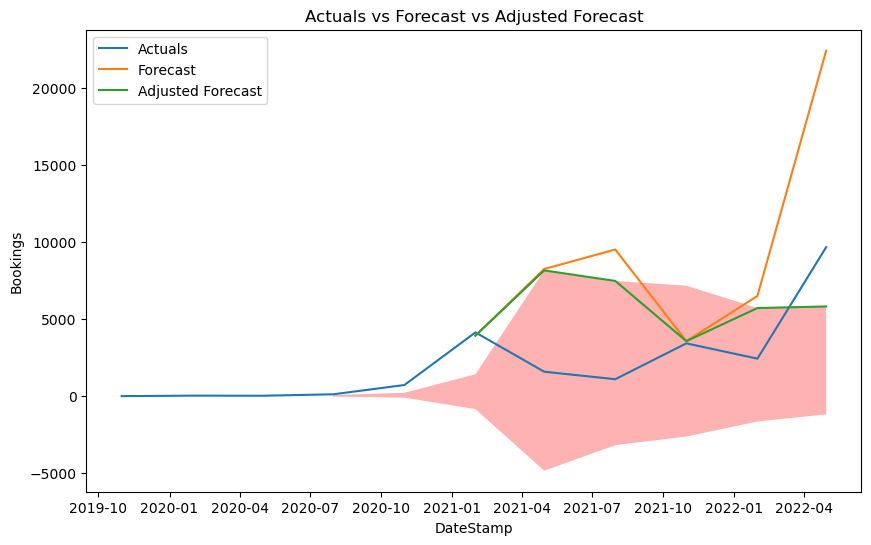

In [591]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))

x = df_final['datestamp']
y1 = df_final['Bookings_3m']
y2 = df_final['Forecast_3m']
y3 = df_final['forecast_adjusted']

# Plotting the first dataset
ax.plot(x, y1, label='Actuals')

# Plotting the second dataset
ax.plot(x, y2, label='Forecast')

# Plotting the second dataset
ax.plot(x, y3, label='Adjusted Forecast')

ax.legend()
ax.set_xlabel('DateStamp')
ax.set_ylabel('Bookings')
ax.set_title('Actuals vs Forecast vs Adjusted Forecast')

y_lower = df_merge['lower limit']
y_upper = df_merge['upper limit']

ax.fill_between(x, y_lower, y_upper, facecolor='red', alpha=0.3)

# Save the graph as an image
img_path = 'graph_image.png'  # Replace this with the path where you want to save the graph image
plt.savefig(img_path)

plt.show()

In [592]:
# Assuming df_final is a pandas DataFrame, not a list
df_analysis = pd.DataFrame()

#Accuracy
#Increase is accuracy is a good thing, looking for positive number in the diff column
# Perform operations on the DataFrame
df_analysis['datestamp'] = df_final['datestamp']
df_analysis['Platform'] = df_final['Platform']
df_analysis['original_accuracy'] = 1 - np.abs((df_final['Forecast_3m'] - df_final['Bookings_3m']) / df_final['Bookings_3m'])
df_analysis['new_accuracy'] = 1 - np.abs((df_final['forecast_adjusted'] - df_final['Bookings_3m']) / df_final['Bookings_3m'])
df_analysis['diff_accuracy'] = df_analysis['new_accuracy'] - df_analysis['original_accuracy']

#SMAPE
#Decrease in SMAPE is a good thing, looking for negative number in the diff column
#=ABS(Forecast-Bookings)/((ABS(Forecast)+ABS(Bookings))/2)
df_analysis['original_SMAPE'] = np.abs(df_final['Forecast_3m'] - df_final['Bookings_3m']) / ((df_final['Forecast_3m'] + df_final['Bookings_3m']) / 2)
df_analysis['new_SMAPE'] = np.abs(df_final['forecast_adjusted'] - df_final['Bookings_3m']) / ((df_final['forecast_adjusted'] + df_final['Bookings_3m']) / 2)
df_analysis['diff_SMAPE'] = df_analysis['new_SMAPE'] - df_analysis['original_SMAPE']


In [593]:
df_final = pd.merge(df_analysis, df_final[['Bookings_3m', 'Forecast_3m', 'forecast_adjusted']], left_index=True, right_index=True, how='left')

In [594]:
df_final

,datestamp,Platform,original_accuracy,new_accuracy,diff_accuracy,original_SMAPE,new_SMAPE,diff_SMAPE,Bookings_3m,Forecast_3m,forecast_adjusted
0,2019-10-31,8k_Chassis,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN
1,2020-01-31,8k_Chassis,NaN,NaN,NaN,NaN,NaN,NaN,36.0,NaN,NaN
2,2020-04-30,8k_Chassis,NaN,NaN,NaN,NaN,NaN,NaN,29.0,NaN,NaN
3,2020-07-31,8k_Chassis,NaN,NaN,NaN,NaN,NaN,NaN,124.0,NaN,NaN
4,2020-10-31,8k_Chassis,NaN,NaN,NaN,NaN,NaN,NaN,724.0,NaN,NaN
5,2021-01-31,8k_Chassis,0.948972,0.948972,0.000000,0.052364,0.052364,0.000000,4135.0,3924.0,3924.000000
6,2021-04-30,8k_Chassis,-3.196721,-3.139561,0.057160,1.354497,1.348488,-0.006010,1586.0,8242.0,8151.343828
7,2021-07-31,8k_Chassis,-6.626134,-4.777980,1.848154,1.584465,1.485728,-0.098737,1102.0,9506.0,7469.334085
8,2021-10-31,8k_Chassis,0.958528,0.958528,0.000000,0.040629,0.040629,0.000000,3424.0,3566.0,3566.000000
9,2022-01-31,8k_Chassis,-0.669544,-0.347892,0.321651,0.909946,0.805218,-0.104728,2433.0,6495.0,5712.421904


### Optional: Printing to an excel sheet

In [358]:
# Create a new Excel workbook
workbook = openpyxl.Workbook()

# Write the DataFrame to the Excel sheet named 'Dataframe'
sheet = workbook.active
sheet.title = 'Dataframe'
for row in df_merge.values.tolist():  # Convert NumPy ndarray to list using tolist()
    sheet.append(row)

# Create a new sheet for the graph
graph_sheet = workbook.create_sheet('Graph')

# Insert the graph image into the "Graph" sheet
img = Image(img_path)
graph_sheet.add_image(img, 'A1')  # Change 'A10' to the desired cell where you want the graph to appear

output_file_path = 'C:/Users/lebobb/Desktop/Adjusted_Forecast.xlsx'  # Replace this with the desired file path
workbook.save(output_file_path)

## Lexi's Revamp PART 2 - 3m Data - Without Actuals Known (Predictions)

### 1. Dropping NA values

In [595]:
# Assuming df is the DataFrame in which you want to drop rows with NaN values

# Drop rows with NaN values in the 'specific_column' column
specific_column = 'forecast_adjusted'  # Replace 'ColumnName' with the name of the column you want to check

# Option 1: Drop rows where 'specific_column' has NaN in any cell
df_final = df_final.dropna(subset=[specific_column], how='any')

# Option 2: Drop rows where 'specific_column' has NaN in all cells
# df = df.dropna(subset=[specific_column], how='all')

# Display the updated DataFrame
print(df_final)

    datestamp    Platform  original_accuracy  new_accuracy  diff_accuracy  \
5  2021-01-31  8k_Chassis           0.948972      0.948972       0.000000   
6  2021-04-30  8k_Chassis          -3.196721     -3.139561       0.057160   
7  2021-07-31  8k_Chassis          -6.626134     -4.777980       1.848154   
8  2021-10-31  8k_Chassis           0.958528      0.958528       0.000000   
9  2022-01-31  8k_Chassis          -0.669544     -0.347892       0.321651   
10 2022-04-30  8k_Chassis          -0.318318      0.602163       0.920482   

    original_SMAPE  new_SMAPE  diff_SMAPE  Bookings_3m  Forecast_3m  \
5         0.052364   0.052364    0.000000       4135.0       3924.0   
6         1.354497   1.348488   -0.006010       1586.0       8242.0   
7         1.584465   1.485728   -0.098737       1102.0       9506.0   
8         0.040629   0.040629    0.000000       3424.0       3566.0   
9         0.909946   0.805218   -0.104728       2433.0       6495.0   
10        0.794570   0.496624   -0

In [596]:
columns_to_drop = ['original_accuracy','new_accuracy','diff_accuracy','original_SMAPE', 'new_SMAPE', 'diff_SMAPE', 'Forecast_3m']
df_final = df_final.drop(columns_to_drop, axis = 1)
df_final.head(20)

,datestamp,Platform,Bookings_3m,forecast_adjusted
5,2021-01-31,8k_Chassis,4135.0,3924.000000
6,2021-04-30,8k_Chassis,1586.0,8151.343828
7,2021-07-31,8k_Chassis,1102.0,7469.334085
8,2021-10-31,8k_Chassis,3424.0,3566.000000
9,2022-01-31,8k_Chassis,2433.0,5712.421904
10,2022-04-30,8k_Chassis,9657.0,5815.090675


### 2. Simple moving average predictive method

In [597]:
def simple_moving_average(data, n):
    forecast = []
    for i in range(len(data) - n):
        forecast.append(sum(data[i:i+n]) / n)
    return forecast

# Example usage
data = df_final['forecast_adjusted']  # Replace this with your own time series data
n = 3  # The number of past data points to consider for prediction

forecast = simple_moving_average(data, n)
print("Original data:", data)
print("Forecasted values:", forecast)


Original data: 5     3924.000000
6     8151.343828
7     7469.334085
8     3566.000000
9     5712.421904
10    5815.090675
Name: forecast_adjusted, dtype: float64
Forecasted values: [6514.892637545275, 6395.559304211941, 5582.585329588757]


In [598]:
def simple_moving_average(data, n):
    forecast = []
    for i in range(len(data) - n):
        forecast.append(sum(data[i:i+n]) / n)
    return forecast

# Example usage
data = df_final['forecast_adjusted']  # Replace this with your own time series data
n = 3  # The number of past data points to consider for prediction

forecast = simple_moving_average(data, n)

# Assuming df_final already has a column called 'forecast'
# If not, you can create a new column using df_final['forecast'] = forecast
df_final['forecast'] = [None] * (n) + forecast

print(df_final)


    datestamp    Platform  Bookings_3m  forecast_adjusted     forecast
5  2021-01-31  8k_Chassis       4135.0        3924.000000          NaN
6  2021-04-30  8k_Chassis       1586.0        8151.343828          NaN
7  2021-07-31  8k_Chassis       1102.0        7469.334085          NaN
8  2021-10-31  8k_Chassis       3424.0        3566.000000  6514.892638
9  2022-01-31  8k_Chassis       2433.0        5712.421904  6395.559304
10 2022-04-30  8k_Chassis       9657.0        5815.090675  5582.585330


In [599]:
#df_final['forecast_adjusted'].append(forecast)

## Lexi's Revamp PART 3 - 3m Data - Adjusting Forecast 2

### 1. Dropping NA values

In [600]:
# Assuming df is the DataFrame in which you want to drop rows with NaN values

# Drop rows with NaN values in the 'specific_column' column
specific_column = 'forecast_adjusted'  # Replace 'ColumnName' with the name of the column you want to check

# Option 1: Drop rows where 'specific_column' has NaN in any cell
df_final = df_final.dropna(subset=[specific_column], how='any')

# Option 2: Drop rows where 'specific_column' has NaN in all cells
# df = df.dropna(subset=[specific_column], how='all')

# Display the updated DataFrame
print(df_final)

    datestamp    Platform  Bookings_3m  forecast_adjusted     forecast
5  2021-01-31  8k_Chassis       4135.0        3924.000000          NaN
6  2021-04-30  8k_Chassis       1586.0        8151.343828          NaN
7  2021-07-31  8k_Chassis       1102.0        7469.334085          NaN
8  2021-10-31  8k_Chassis       3424.0        3566.000000  6514.892638
9  2022-01-31  8k_Chassis       2433.0        5712.421904  6395.559304
10 2022-04-30  8k_Chassis       9657.0        5815.090675  5582.585330


In [563]:
columns_to_drop = ['original_accuracy','new_accuracy','diff_accuracy','original_SMAPE', 'new_SMAPE', 'diff_SMAPE', 'Forecast_3m']
df_final = df_final.drop(columns_to_drop, axis = 1)
df_final.head(20)

,datestamp,Platform,Bookings_3m,forecast_adjusted,forecast
5,2021-01-31,8k_Chassis,4135.0,3924.000000,NaN
6,2021-04-30,8k_Chassis,1586.0,8151.343828,NaN
7,2021-07-31,8k_Chassis,1102.0,7469.334085,NaN
8,2021-10-31,8k_Chassis,3424.0,3566.000000,6514.892638
9,2022-01-31,8k_Chassis,2433.0,5712.421904,6395.559304
10,2022-04-30,8k_Chassis,9657.0,5815.090675,5582.585330


In [601]:
# Calculate the mean and deviation over a rolling window of 3 quarters for Forecast
df_final = df_final.sort_values(by="datestamp")
df_final['mean'] = df_final['forecast_adjusted'].rolling(window=3).mean()
df_final['deviation'] = df_final['forecast_adjusted'].rolling(window=3).std()

# The naive mean and naive deviation are the last values from the 'mean' and 'deviation' columns
df_final['naivemean'] = df_final['mean'].shift(1)
df_final['naivedeviation'] = df_final['deviation'].shift(1)

# Calculate the lower limit and upper limit based on naivemean and naivedeviation
df_final['lower limit'] = df_final['naivemean'] - 3*df_final['naivedeviation']
df_final['upper limit'] = df_final['naivemean'] + 3*df_final['naivedeviation']

In [524]:
df_final

,datestamp,Platform,Bookings_3m,forecast_adjusted,mean,deviation,naivemean,naivedeviation,lower limit,upper limit
5,2021-01-31,8k_Chassis,4135.0,3924.000000,NaN,NaN,NaN,NaN,NaN,NaN
6,2021-04-30,8k_Chassis,1586.0,8151.343828,NaN,NaN,NaN,NaN,NaN,NaN
7,2021-07-31,8k_Chassis,1102.0,7469.334085,6514.892638,2269.543526,NaN,NaN,NaN,NaN
8,2021-10-31,8k_Chassis,3424.0,3566.000000,6395.559304,2474.083409,6514.892638,2269.543526,-293.737941,13323.523216
9,2022-01-31,8k_Chassis,2433.0,5712.421904,5582.585330,1954.903424,6395.559304,2474.083409,-1026.690923,13817.809531
10,2022-04-30,8k_Chassis,9657.0,5815.090675,5031.170860,1269.913168,5582.585330,1954.903424,-282.124942,11447.295601
